In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Read in dataframe and view first few rows
path = '/content/drive/MyDrive/MLProject/data/Airbnb_Data_Images.csv'
df = pd.read_csv(path)
df.head()

#Retain only NYC listings
df_nyc = df[df['city'] == 'NYC']
df_nyc.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Index: 24688 entries, 0 to 53061
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      24688 non-null  int64  
 1   log_price               24688 non-null  float64
 2   property_type           24688 non-null  object 
 3   room_type               24688 non-null  object 
 4   amenities               24688 non-null  object 
 5   accommodates            24688 non-null  int64  
 6   bathrooms               24622 non-null  float64
 7   bed_type                24688 non-null  object 
 8   cancellation_policy     24688 non-null  object 
 9   cleaning_fee            24688 non-null  bool   
 10  city                    24688 non-null  object 
 11  description             24688 non-null  object 
 12  first_review        

In [ ]:
df_nyc[['log_price', 'property_type', 'accommodates', 'review_scores_rating', 'bedrooms', 'amenities']]

,log_price,property_type,accommodates,review_scores_rating,bedrooms,amenities
0,5.010635,Apartment,3,100.0,1.0,"{""Wireless Internet"",""Air conditioning"",Kitche..."
1,5.129899,Apartment,7,93.0,3.0,"{""Wireless Internet"",""Air conditioning"",Kitche..."
8,4.605170,Apartment,2,93.0,1.0,"{Internet,""Wireless Internet"",""Air conditionin..."
13,3.688879,House,2,89.0,1.0,"{Internet,""Air conditioning"",Kitchen,""Smoking ..."
16,5.003946,Apartment,6,100.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
...,...,...,...,...,...,...
53051,3.688879,Apartment,2,86.0,1.0,"{TV,Internet,""Wireless Internet"",""Air conditio..."
53052,3.912023,Apartment,2,60.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
53053,4.700480,Apartment,2,92.0,1.0,"{Internet,""Wireless Internet"",""Air conditionin..."
53060,4.605170,Apartment,1,NaN,1.0,{}


Feature Engineering and Preprocessing steps
1. Create new features based on existing ones that seem relevant for our task
2. Remove variables that do not make business sense in predicting `review_scores_rating`
3. Handle missing values
4. Scale the numeric features so they are standardized
5. Bin categorical features to have roughly even groupings
6. Retain top amenities and create binary columns for each
7. Apply one-hot encoding for categorical features
8. Bin the `review_scores_rating` field into roughly equal groupings
9. Combine text data columns
10. Test initial models

## 1. Feature Engineering

In [ ]:
#Feature Engineering to create some new columns
df_nyc.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [ ]:
#Convert 'first_review' and 'last_review' columns to datetime
df_nyc['first_review'] = pd.to_datetime(df_nyc['first_review'], errors='coerce')
df_nyc['last_review'] = pd.to_datetime(df_nyc['last_review'], errors='coerce')

#Calculate the number of days between 'first_review' and 'last_review'
df_nyc['days_between_reviews'] = (df_nyc['last_review'] - df_nyc['first_review']).dt.days


<ipython-input-18-7258ea7fe389>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['first_review'] = pd.to_datetime(df_nyc['first_review'], errors='coerce')
<ipython-input-18-7258ea7fe389>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['last_review'] = pd.to_datetime(df_nyc['last_review'], errors='coerce')
<ipython-input-18-7258ea7fe389>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [ ]:
#Create price per capacity feature, price relative to number accommodates
df_nyc['price_per_capacity'] = df['log_price'] / df['accommodates']

<ipython-input-19-c702ea407e6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['price_per_capacity'] = df['log_price'] / df['accommodates']


In [ ]:
#Convert 'host_since' to datetime
df_nyc['host_since'] = pd.to_datetime(df_nyc['host_since'], errors='coerce')

#Calculate days active since 'host_since' to the current date
df_nyc['host_days_active'] = (datetime.now() - df_nyc['host_since']).dt.days


<ipython-input-20-709550992846>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['host_since'] = pd.to_datetime(df_nyc['host_since'], errors='coerce')
<ipython-input-20-709550992846>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['host_days_active'] = (datetime.now() - df_nyc['host_since']).dt.days


In [ ]:
#We want to compare latitude/longitude of the listings to a popular attraction like Times Square
#Constants for Times Square's coordinates
times_square_lat = 40.758896
times_square_lon = -73.985130

#Calculate Euclidean distance to Times Square
df_nyc['distance_to_times_square'] = np.sqrt((df_nyc['latitude'] - times_square_lat)**2 +
                                             (df_nyc['longitude'] - times_square_lon)**2)


<ipython-input-21-8054775cc33f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['distance_to_times_square'] = np.sqrt((df_nyc['latitude'] - times_square_lat)**2 +


In [ ]:
#Find room capacity using bedrooms and accommodates
df_nyc['room_capacity'] = df_nyc['accommodates'] / df_nyc['bedrooms']

<ipython-input-22-b99a627f3388>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['room_capacity'] = df_nyc['accommodates'] / df_nyc['bedrooms']


In [ ]:
#Converting 'host_response_rate' from string percentage to float
df_nyc['host_response_rate'] = df_nyc['host_response_rate'].str.rstrip('%').astype('float')

<ipython-input-23-2b6daf772977>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['host_response_rate'] = df_nyc['host_response_rate'].str.rstrip('%').astype('float')


In [ ]:
#Adjust price column to get raw value
df_nyc['price'] = np.exp(df_nyc['log_price'])

#Create 3 equal buckets for the 'price' field using qcut
df_nyc['price_bucket'], bin_edges = pd.qcut(
    df_nyc['price'],
    q=3,
    labels=['Low', 'Medium', 'High'],
    retbins=True
)

#Display the numeric ranges for the buckets
print("Numeric ranges for the price buckets:")
for i in range(len(bin_edges) - 1):
    print(f"Bucket {i+1} ({['Low', 'Medium', 'High'][i]}): {bin_edges[i]:.2f} to {bin_edges[i+1]:.2f}")

#Check the distribution of buckets
print("\nBucket distribution:")
print(df_nyc['price_bucket'].value_counts())

Numeric ranges for the price buckets:
Bucket 1 (Low): 1.00 to 80.00
Bucket 2 (Medium): 80.00 to 150.00
Bucket 3 (High): 150.00 to 1999.00

Bucket distribution:
price_bucket
Medium    8829
Low       8472
High      7387
Name: count, dtype: int64


<ipython-input-24-18e292c42f13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['price'] = np.exp(df_nyc['log_price'])
<ipython-input-24-18e292c42f13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['price_bucket'], bin_edges = pd.qcut(


In [ ]:
#Define the mapping for rating_bucket
price_bucket_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

#Apply the mapping to the 'rating_bucket' column
df_nyc['price_bucket'] = df_nyc['price_bucket'].map(price_bucket_mapping)

# Verify the conversion
print(df_nyc['price_bucket'].value_counts())

price_bucket
1    8829
0    8472
2    7387
Name: count, dtype: int64


<ipython-input-25-96cfd938cc75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['price_bucket'] = df_nyc['price_bucket'].map(price_bucket_mapping)


In [ ]:
df_nyc['price_bucket'] = df_nyc['price_bucket'].astype(int)

<ipython-input-26-4b6e5d75d1da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['price_bucket'] = df_nyc['price_bucket'].astype(int)


## 2. Remove Irrelevant or Highly Correlated Variables

In [ ]:
#Dropping specified columns
columns_to_drop = ['id', 'first_review', 'last_review', 'latitude', 'longitude',
                   'thumbnail_url', 'zipcode', 'city', 'host_since', 'beds', 'bed_type', 'log_price', 'price']
df_nyc = df_nyc.drop(columns=columns_to_drop, errors='ignore')

# Display the updated DataFrame's columns
print(df_nyc.columns)

Index(['property_type', 'room_type', 'amenities', 'accommodates', 'bathrooms',
       'cancellation_policy', 'cleaning_fee', 'description',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'instant_bookable', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'bedrooms', 'days_between_reviews',
       'price_per_capacity', 'host_days_active', 'distance_to_times_square',
       'room_capacity', 'price_bucket'],
      dtype='object')


## 3. Handle Missing Values

In [ ]:
#Drop rows with missing review score ratings to maintain outcome integrity
#We do not want to introduce noise/variability in the outcome
df_nyc = df_nyc.dropna(subset=['review_scores_rating'])

In [ ]:
# Selecting the numeric fields for imputation
fields_to_impute = ['bathrooms', 'host_response_rate', 'bedrooms', 'host_days_active', 'room_capacity']

# Replace inf/-inf values with NaN
df_nyc[fields_to_impute] = df_nyc[fields_to_impute].replace([np.inf, -np.inf], np.nan)

# Applying Iterative Imputer after handling inf values
imputer = IterativeImputer(max_iter=10, random_state=0)
df_nyc[fields_to_impute] = imputer.fit_transform(df_nyc[fields_to_impute])

# Displaying the first few rows to verify imputation
print(df_nyc[fields_to_impute].head())


    bathrooms  host_response_rate  bedrooms  host_days_active  room_capacity
0         1.0           94.687082       1.0            4638.0       3.000000
1         1.0          100.000000       3.0            2727.0       2.333333
8         1.0          100.000000       1.0            4272.0       2.000000
13        1.5          100.000000       1.0            3754.0       2.000000
16        1.0          100.000000       3.0            2887.0       2.000000


In [ ]:
# Selecting the categorical fields for imputation
cat_fields = ['host_has_profile_pic', 'host_identity_verified', 'neighbourhood']

# Impute categorical columns with mode = different method?
for col in cat_fields:
    df_nyc[col] = df_nyc[col].fillna(df_nyc[col].mode()[0])


<ipython-input-30-2c665f8334e0>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_nyc[col] = df_nyc[col].fillna(df_nyc[col].mode()[0])


## 4. Scale Numeric Features

In [ ]:
# List of numeric features and the outcome variable
numeric_features = ['accommodates', 'bathrooms', 'host_response_rate',
                    'number_of_reviews', 'bedrooms', 'days_between_reviews',
                    'price_per_capacity', 'host_days_active', 'distance_to_times_square',
                    'room_capacity']

# Standardize the numeric features including the outcome variable
scaler = StandardScaler()
df_nyc[numeric_features] = scaler.fit_transform(df_nyc[numeric_features])


In [ ]:
#Convert column 'cleaning_fee' to binary (1 for True, 0 for False)
df_nyc['cleaning_fee'] = df_nyc['cleaning_fee'].astype(int)

#Convert column 'host_has_profile_pic' to binary (1 for True, 0 for False)
df_nyc['host_has_profile_pic'] = df_nyc['host_has_profile_pic'].astype(int)

#Convert column 'host_identity_verified' to binary (1 for True, 0 for False)
df_nyc['host_identity_verified'] = df_nyc['host_identity_verified'].astype(int)

#Convert column 'instant_bookable' to binary (1 for True, 0 for False)
df_nyc['instant_bookable'] = df_nyc['instant_bookable'].astype(int)

## 5. Bin Categorical Features into Even Groups

In [ ]:
#Define a list of categories to bin into "Other"
categories_to_bin = ['Bed & Breakfast', 'Guest suite', 'Timeshare', 'Guesthouse', 'Hostel',
                     'Villa', 'Bungalow', 'Dorm', 'Boutique hotel', 'Serviced apartment',
                     'Boat', 'In-law', 'Vacation home', 'Chalet', 'Yurt', 'Cabin',
                     'Earth House', 'Castle']

#Update 'property_type' column
df_nyc['property_type'] = df_nyc['property_type'].apply(lambda x: 'Other' if x in categories_to_bin else x)

#Verify the new value counts
df_nyc['property_type'].value_counts()


,count
property_type,
Apartment,16089
House,1534
Loft,350
Townhouse,338
Other,277
Condominium,243


In [ ]:
df_nyc['neighbourhood'].value_counts()

,count
neighbourhood,
Williamsburg,1684
Bedford-Stuyvesant,1351
Bushwick,920
Upper West Side,826
Hell's Kitchen,793
...,...
Annadale,1
Oakwood,1
Van Nest,1


In [ ]:
#Calculate total number of neighborhoods and cumulative counts
total_neighborhoods = df_nyc['neighbourhood'].value_counts()

#Determine thresholds for grouping (e.g., top 10%, 10%-40%, and remaining)
high_threshold = total_neighborhoods.quantile(0.9)
medium_threshold = total_neighborhoods.quantile(0.6)

#Apply binning based on thresholds
def bin_neighbourhood(neighbourhood):
    count = total_neighborhoods.get(neighbourhood, 0)
    if count >= high_threshold:
        return 'High Frequency'
    elif count >= medium_threshold:
        return 'Medium Frequency'
    else:
        return 'Low Frequency'

#Create a new grouped neighbourhood feature
df_nyc['neighbourhood_group'] = df_nyc['neighbourhood'].apply(bin_neighbourhood)

#Check value counts for the new groups
print(df_nyc['neighbourhood_group'].value_counts())


neighbourhood_group
High Frequency      12438
Medium Frequency     5572
Low Frequency         821
Name: count, dtype: int64


In [ ]:
#Dropping neighbourhood
drop_neighbourhood = ['neighbourhood']
df_nyc = df_nyc.drop(columns=drop_neighbourhood, errors='ignore')

In [ ]:
#Update 'cancellation_policy' by combining 'super_strict_30' and 'super_strict_60' into 'strict'
df_nyc['cancellation_policy'] = df_nyc['cancellation_policy'].replace({'super_strict_30': 'strict', 'super_strict_60': 'strict'})

## 6. Retain top amenities and create binary columns for each

In [ ]:
#Top 10 amenities to check using the plot from EDA
top_amenities = [
    "wireless internet", "kitchen", "heating", "essentials",
    "air conditioning", "smoke detector", "tv", "hangers",
    "carbon monoxide detector", "shampoo"
]

#Strip any formatting from the amenities strings for standardization
df_nyc['amenities'] = df_nyc['amenities'].str.lower().str.replace('"', '').str.replace('{', '').str.replace('}', '')

# Create a column for each top amenity
for amenity in top_amenities:
    column_name = amenity.lower().replace(" ", "_")  # Create column names
    df_nyc[column_name] = df_nyc['amenities'].apply(lambda x: int(amenity.lower() in x))

In [ ]:
#Drop amenities
drop_amenities = ['amenities']
df_nyc = df_nyc.drop(columns=drop_amenities, errors='ignore')

## 7. Apply one-hot encoding for categorical features

In [ ]:
categorical_columns = ['property_type', 'room_type', 'cancellation_policy', 'neighbourhood_group']
df_nyc = pd.get_dummies(df_nyc, columns=categorical_columns, drop_first=True, dtype = int)

## 8. Bin the review_scores_rating field into roughly equal groupings

    review_scores_rating  rating_bucket
0                  100.0  Perfect Score
1                   93.0     High Score
8                   93.0     High Score
13                  89.0      Low Score
16                 100.0  Perfect Score


<ipython-input-27-835ef1ada224>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_nyc, x='rating_bucket', palette='viridis')


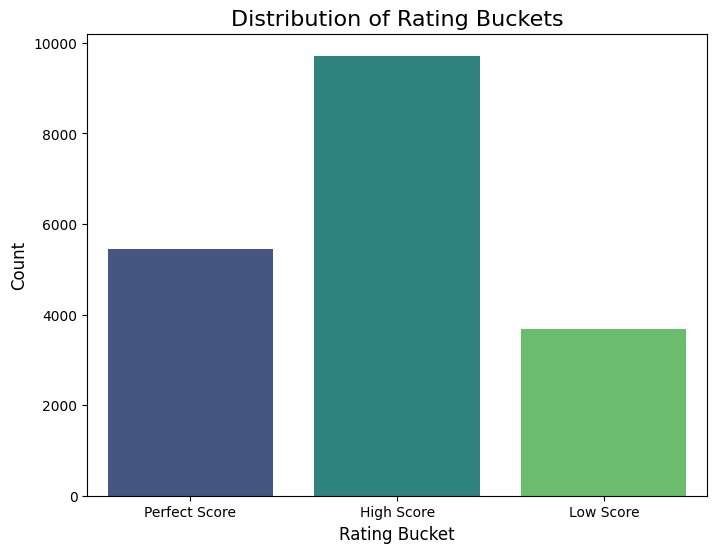

In [ ]:
def bucketize_rating(rating):
    if rating == 100:
        return 'Perfect Score'
    elif 90 <= rating <= 99:
        return 'High Score'
    else:
        return 'Low Score'

df_nyc['rating_bucket'] = df_nyc['review_scores_rating'].apply(bucketize_rating)

#Check the result
print(df_nyc[['review_scores_rating', 'rating_bucket']].head())


#Distribution of bucketized ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df_nyc, x='rating_bucket', palette='viridis')

plt.title('Distribution of Rating Buckets', fontsize=16)
plt.xlabel('Rating Bucket', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [ ]:
#View the counts in each bin
df_nyc['rating_bucket'].value_counts()

,count
rating_bucket,
High Score,9716
Perfect Score,5443
Low Score,3672


In [ ]:
#Dropping review score rating and using the rating bucket as target
drop_score = ['review_scores_rating']
df_nyc = df_nyc.drop(columns=drop_score, errors='ignore')

In [ ]:
# Define the mapping for rating_bucket
rating_bucket_mapping = {'Low Score': 0, 'High Score': 1, 'Perfect Score': 2}

# Apply the mapping to the 'rating_bucket' column
df_nyc['rating_bucket'] = df_nyc['rating_bucket'].map(rating_bucket_mapping)

# Verify the conversion
print(df_nyc['rating_bucket'].value_counts())


rating_bucket
1    9716
2    5443
0    3672
Name: count, dtype: int64


## 9. Combine Text Data Columns

In [ ]:
df_nyc['text'] = df_nyc['name'] + ' ' + df_nyc['description']

In [ ]:
#Dropping description and name
drop_text = ['description', 'name']
df_nyc = df_nyc.drop(columns=drop_text, errors='ignore')

In [ ]:
df_nyc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18831 entries, 0 to 53061
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   accommodates                          18831 non-null  float64
 1   bathrooms                             18831 non-null  float64
 2   cleaning_fee                          18831 non-null  int64  
 3   host_has_profile_pic                  18831 non-null  int64  
 4   host_identity_verified                18831 non-null  int64  
 5   host_response_rate                    18831 non-null  float64
 6   instant_bookable                      18831 non-null  int64  
 7   number_of_reviews                     18831 non-null  float64
 8   bedrooms                              18831 non-null  float64
 9   days_between_reviews                  18831 non-null  float64
 10  price_per_capacity                    18831 non-null  float64
 11  host_days_active    

In [ ]:
from google.colab import files

# Save the DataFrame to a CSV file
df_nyc.to_csv('df_clean.csv', index=False)

# Download the CSV file to your laptop
files.download('df_clean.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Part 10: Model Development

## Tabular Data Development

In [ ]:
from sklearn.model_selection import train_test_split

X = df_nyc.drop('rating_bucket', axis=1)

#Features (exclude the target column)
y = df_nyc['rating_bucket']
#Target variable
#Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Prepare data
X_train_tabular = X_train.drop(columns=['text'])
X_test_tabular = X_test.drop(columns=['text'])

#Initialize the XGBoost classifier
xgb_tabular = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eta=0.1, max_depth=5, n_estimators=100)

#Fit the model
xgb_tabular.fit(X_train_tabular, y_train)

#Make predictions
y_pred_tabular = xgb_tabular.predict(X_test_tabular)
accuracy_tabular = accuracy_score(y_test, y_pred_tabular)
print(f"Accuracy (Tabular Only): {accuracy_tabular}")

#Precision, Recall, and Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tabular))

#Compute Precision and Recall (macro-averaged)
precision_tabular = precision_score(y_test, y_pred_tabular, average='macro')
recall_tabular = recall_score(y_test, y_pred_tabular, average='macro')
print(f"Precision (Tabular Only): {precision_tabular}")
print(f"Recall (Tabular Only): {recall_tabular}")

#Compute ROC AUC (requires one-hot encoded y_test and probabilities)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba = xgb_tabular.predict_proba(X_test_tabular)
roc_auc_tabular = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print(f"ROC AUC (Tabular Only): {roc_auc_tabular}")

#Evaluate using regression metrics
'''
mse_tabular = mean_squared_error(y_test, y_pred_tabular)
mae_tabular = mean_absolute_error(y_test, y_pred_tabular)
r2_tabular = r2_score(y_test, y_pred_tabular)

print(f"Mean Squared Error (Tabular Only): {mse_tabular}")
print(f"Mean Absolute Error (Tabular Only): {mae_tabular}")
print(f"R² Score (Tabular Only): {r2_tabular}")
'''

Accuracy (Tabular Only): 0.6732147597557738

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.08      0.13       757
           1       0.71      0.88      0.79      1941
           2       0.61      0.73      0.67      1069

    accuracy                           0.67      3767
   macro avg       0.61      0.56      0.53      3767
weighted avg       0.64      0.67      0.62      3767

Precision (Tabular Only): 0.6076594305132085
Recall (Tabular Only): 0.5597992970770181
ROC AUC (Tabular Only): 0.8028876309454822


'\nmse_tabular = mean_squared_error(y_test, y_pred_tabular)\nmae_tabular = mean_absolute_error(y_test, y_pred_tabular)\nr2_tabular = r2_score(y_test, y_pred_tabular)\n\nprint(f"Mean Squared Error (Tabular Only): {mse_tabular}")\nprint(f"Mean Absolute Error (Tabular Only): {mae_tabular}")\nprint(f"R² Score (Tabular Only): {r2_tabular}")\n'

## Text Data Development

In [ ]:
#Testing textual analysis
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Function to extract BERT embeddings
def get_bert_embeddings(texts, tokenizer, bert_model):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Move inputs to GPU
    inputs = {key: val.to(device) for key, val in inputs.items()}

    bert_model.eval()
    outputs = bert_model(inputs['input_ids'])
    # Use the mean of the last hidden state as the embeddings
    return np.mean(outputs.last_hidden_state.detach().cpu().numpy(), axis=1).squeeze()



In [ ]:
def create_embeddings(df):
    """
    Parameters::
        df: DataFrame with a column named "text"

    Returns::
        emb_df: DataFrame with 768 columns; each row contains the embeddings for the text in the corresponding row of df.
    """
    embeddings = []

    # Loop through the rows of the dataframe. Pass the text through the bert model and get embeddings using the get_bert_embeddings function
    for i in tqdm(range(0, df.shape[0])):
        text = df['text'].iloc[i] # TODO
        full_embedding = get_bert_embeddings(texts = text, tokenizer= tokenizer, bert_model= bert_model) # TODO
        embeddings.append(full_embedding) # TODO (or = full_embedding?)

    emb_df =  pd.DataFrame(np.array(embeddings), columns=[f"emb_{i}" for i in range(768)])

    emb_df = emb_df.set_index(df.index)

    return emb_df

In [ ]:
#Apply BERT embeddings on train and test text data
X_train_text_bert = create_embeddings(X_train)
X_test_text_bert = create_embeddings(X_test)

### Step 3: XGBoost on Text Data Only ###

#XGBoost on text data
xgb_text = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eta=0.1, max_depth = 5, n_estimators=100)

#Fit the model
xgb_text.fit(X_train_text_bert, y_train)

#Evaluate on test set
y_pred_text = xgb_text.predict(X_test_text_bert)
accuracy_text = accuracy_score(y_test, y_pred_text)
print(f"Accuracy (Text Only): {accuracy_text}")

100%|██████████| 3767/3767 [01:03<00:00, 59.25it/s]


Accuracy (Text Only): 0.5261481284842049


In [ ]:
#df_nyc.to_csv('df_nyc.csv', index=False)

In [ ]:
#Combine tabular features and BERT embeddings
X_combined = pd.concat([X_train_tabular, X_train_text_bert], axis = 1)
X_combined_test = pd.concat([X_test_tabular, X_test_text_bert], axis = 1)

#XGBoost on combined data
xgb_combined = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eta=0.1, max_depth = 5, n_estimators=100)

#Fit the model
xgb_combined.fit(X_combined, y_train)

#Evaluate on test set
y_pred_combined = xgb_combined.predict(X_combined_test)
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Accuracy (Combined): {accuracy_combined}")

Accuracy (Combined): 0.6710910538890363
